In [196]:
import numpy as np
import matplotlib.pyplot as plt

# ΜΕΡΟΣ Α
_________________________________________________________________________

Υλοποίηση της κλάσης Classifier:

In [197]:
class Classifier_ML:

    theta_estimation_1 = None
    theta_estimation_2 = None

    
    def fit(self, D, thetas, target_class):

        if (target_class not in [1,2]):
            raise Exception ("Non valid target class!")
        
        # Calculate for every sample and every theta, the probability p(x|theta)
        probs_x_theta = (1/np.pi) * (1 / (1 + (D[:, np.newaxis] - thetas)**2))  

        # Compute p(D|theta) as the product for each theta (along axis 0)
        probs_D_theta = np.prod(probs_x_theta, axis=0)

        # Get the value of theta that maximizes the probability p(D|theta)

        if (target_class==1):
            self.theta_estimation_1 = thetas[np.argmax(probs_D_theta)]
        else:
            self.theta_estimation_2 = thetas[np.argmax(probs_D_theta)]

        return probs_D_theta

    
    def predict(self, D, P1, P2):
        
        # Calculate for every sample the probability p(x|theta_1)
        P_x_th1 = (1/np.pi) * (1 / (1 + (D - self.theta_estimation_1)**2))

        # Calculate for every sample the probability p(x|theta_2)
        P_x_th2 = (1/np.pi) * (1 / (1 + (D - self.theta_estimation_2)**2))

        # Calculate the logs of the a priori probabilities
        log_P1 = np.log10(P1)
        log_P2 = np.log10(P2)

        # Return g(x) for every x
        return np.log10(P_x_th1) - np.log10(P_x_th2) + log_P1 - log_P2

    


### Ερώτημα α

Υπολογισμός της εκτίμησης του θ και plotting της πιθανότητας των dataset D1, D2:

2.5250501002003958 
 -3.2464929859719476


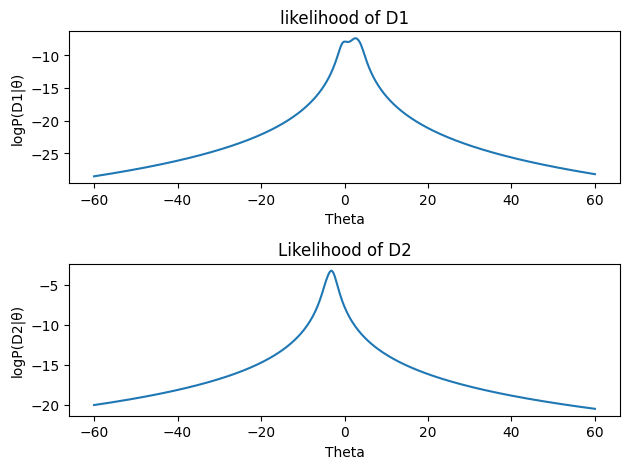

In [198]:
# Create 2 Classifier objects
classifier = Classifier_ML()

# Fit models to observations 
D1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])
thetas1 = np.linspace(-60, 60, 500)
probs_D_theta1 = classifier.fit(D1, thetas1, 1)

D2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])
thetas2 = np.linspace(-60, 60, 500)
probs_D_theta2 = classifier.fit(D2, thetas2, 2)

print(classifier.theta_estimation_1, "\n", classifier.theta_estimation_2)

# Plot log( p(D|theta) ) for both classes
fig, ax = plt.subplots(2, 1)
ax[0].plot(thetas1, np.log10(probs_D_theta1))
ax[0].set_title("likelihood of D1")
ax[0].set_xlabel("Theta")
ax[0].set_ylabel("logP(D1|θ)")
ax[1].plot(thetas2, np.log10(probs_D_theta2))
ax[1].set_xlabel("Theta")
ax[1].set_ylabel("logP(D2|θ)")
ax[1].set_title("Likelihood of D2")
fig.tight_layout()
plt.show()

### Ερώτημα β


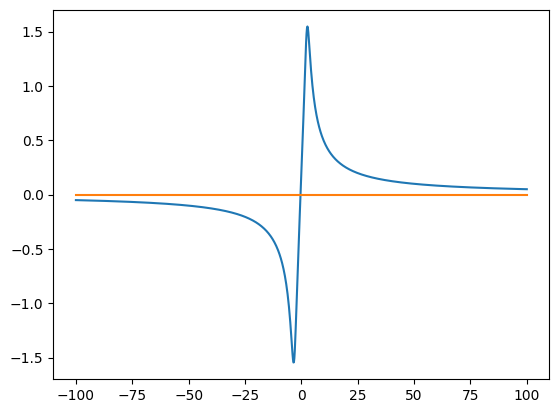

In [199]:
D = np.linspace(-100, 100, 1000)

prediction = classifier.predict(D, 0.5, 0.5)

zero = np.zeros_like(D)
plt.plot(D, prediction)
plt.plot(D, zero)

# ΜΕΡΟΣ Β
____________________________________________________________________________________

In [200]:
def trapezoid_integral (f:np.array, dx:float):
    return np.sum (0.5 * ( f[0:len(f)-1] + f[1:len(f)] ) * dx)


In [201]:
class Classifier_Bayes:
    P_x_D1 = None
    P_x_D2 = None

    def fit(self, D, thetas, dtheta, target_class):

        if (target_class not in [1,2]):
            raise Exception ("Non valid target class!")
        
        # Calculate for every sample and every theta, the probability p(x|theta)
        probs_x_theta = (1/np.pi) * (1 / (1 + (D[:, np.newaxis] - thetas)**2))  

        # Compute p(D|theta) as the product for each theta (along axis 0)
        probs_D_theta = np.prod(probs_x_theta, axis=0)  

        # Calculate prior probability p(theta)
        probs_theta = ( 1 / 10*np.pi ) * ( 1 / ( 1 + (thetas/10)**2 ) )

        # Calculate integral p(D|theta)p(theta) dtheta
        integral = trapezoid_integral( probs_D_theta * probs_theta, dtheta )

        # Calculate a posteriori probability p(theta|D)
        P_theta_D = ( probs_D_theta * probs_theta ) / integral

        probs_x_theta = (1/np.pi) * (1 / (1 + (D1[:, np.newaxis] - thetas)**2))

        probs_x_D = np.empty(len(D1))
        for i in range (len(D1)):
            probs_x_D[i] = trapezoid_integral( probs_x_theta[i] * P_theta_D, dtheta )

        if (target_class==1):
            self.P_x_D1 = probs_x_theta
            return P_theta_D
        else:
            self.P_x_D2 = probs_x_theta
            return P_theta_D


    def predict(self, D, D1, D2, P1, P2):
        return np.log10(self.P_x_D1) - np.log10(self.P_x_D2) + np.log10(P1) - np.log10(P2)


### Ερώτημα α

Plot p(theta|D)

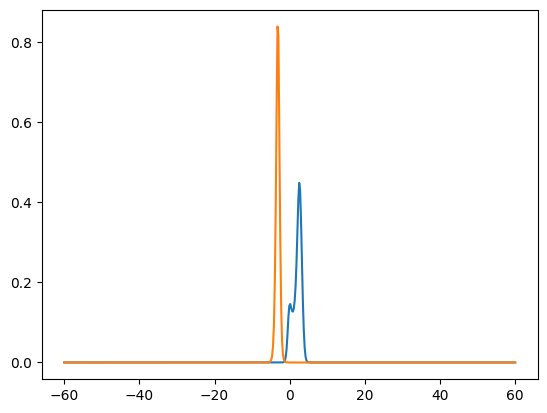

In [202]:
classifier_bayes = Classifier_Bayes()

plt.plot(thetas1, classifier_bayes.fit(D1, thetas1, 120/500, 1))

plt.plot(thetas2, classifier_bayes.fit(D2, thetas2, 120/500, 2))


### Ερώτημα β


TypeError: Classifier_Bayes.predict() missing 1 required positional argument: 'P2'